# Initialization

In [1]:
import numpy as np
from tqdm import tqdm
import os
import sys

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rc('font', size=16)
plt.rcParams['figure.figsize'] = (12.0, 10.0)    # resize plots

# Getting dataset information

Any analysis starts with selecting datasets. This loads in a CSV containing the XENON100 runs info for run10. You can make a similar one for other runs by copy-pasting the wiki table in a spreadsheet program, then saving as csv.

In [162]:
import pandas as pd
datasets = pd.read_csv('xenon100_run10_runs.csv')

def get_dataset_info(dataset_name):
    """Returns a dictionary with the runs database info for a given dataset"""
    return datasets[datasets['name'] == dataset_name].iloc[0].to_dict()
    
get_dataset_info('xe100_120401_2201')

{'anode': 4.4000000000000004,
 'category': 'standard',
 'cathode': 16.0,
 'comment': nan,
 'corrected_events': 22091.0,
 'corrected_livetime': 39603.300000000003,
 'events': 32098,
 'livetime': 39603.300000000003,
 'name': 'xe100_120401_2201',
 'position': 'other',
 'processed': '0.4.5',
 'shield': 'closed',
 'source': 'Dark Matter',
 'trigger': 'S1'}

Here's an example to get all standard AmBe datasets:

In [3]:
datasets.query('source == "AmBe" & category == "standard"')['name'].values

array(['xe100_110210_1100', 'xe100_110210_1106', 'xe100_110210_1412',
       'xe100_110210_1502', 'xe100_110210_1709', 'xe100_110210_1926',
       'xe100_110210_2211', 'xe100_110210_2341', 'xe100_110211_0059',
       'xe100_110211_0315', 'xe100_110211_0532', 'xe100_110211_0614',
       'xe100_110211_0935', 'xe100_110211_1243', 'xe100_120402_1116',
       'xe100_120402_1415', 'xe100_120402_1727', 'xe100_120402_2000',
       'xe100_120402_2233', 'xe100_120403_0107', 'xe100_120403_0340',
       'xe100_120403_0615', 'xe100_120403_0850', 'xe100_120403_1125',
       'xe100_120403_1400', 'xe100_120403_1634', 'xe100_120403_1910',
       'xe100_120403_2145', 'xe100_120404_0020', 'xe100_120404_0255',
       'xe100_120404_0529', 'xe100_120404_0804'], dtype=object)

This counts the data livetime in days for each source, considering only standard datasets:

In [4]:
standard_datasets = datasets[datasets['category'] == 'standard']
pd.groupby(standard_datasets, 'source')['livetime'].sum() / (3600 * 24)

source
AmBe             3.005850
Co60            22.567252
Cs137            6.230497
Dark Matter    231.763412
Th232           25.638033
Name: livetime, dtype: float64

# Looping over ROOT files

The default pax output format is a ROOT file containing an event class. While you could analyze them with TTree.Draw(...) (in python or C++), you have much more control if you loop over the events. Here is a basic function which allows you to run a custom function of every event in one or more pax root files:

In [103]:
ROOTFILES_PATHS = ['/archive_lngs/common/PaxReprocessed_7', '/archive_lngs/common/PaxReprocessed_6']
BASIC_BRANCHES = ['s1s', 's2s', 'event_number', 'start_time', 'stop_time',
                  'peaks.area', 'peaks.type',
                  'interactions.s1', 'interactions.s2',
                  'interactions.s1_area_correction', 'interactions.s2_area_correction',
                  'interactions.x', 'interactions.y', 'interactions.z', 
                  ]

# Load ROOT and the pax event class (you must provide this in the current working directory)
# The first time you load it, it will be slow, because it has to compile the .so
import ROOT
from pax.plugins.io.ROOTClass import load_event_class
load_event_class('pax_event_class_410.cpp')

# An exception you can raise to stop looping over the current dataset
class StopEventLoop(Exception):
    pass

def find_file_in_folders(filename, folders):
    """Searches for filename in folders, then return full path or raise FileNotFoundError"""
    # Find the file for this dataset
    for folder in folders:
        full_path = os.path.join(folder, filename)
        if os.path.exists(full_path):
            return full_path
    raise FileNotFoundError("Did not find file %s!" % filename)

def loop_over_dataset(dataset, event_function=lambda event: None, branch_selection=BASIC_BRANCHES):
    """Execute event_function(event) over all events in the dataset
    Does not return anything: you have to keep track of results yourself (global vars, function attrs, classes, ...)
    branch selection is either None (in which case all branches are read), or a list of branches to activate.
    """    
    # Open the file, load the tree
    # If you get "'TObject' object has no attribute 'GetEntries'" here,
    # we renamed the tree to T1 or TPax or something
    rootfile_name = find_file_in_folders(dataset + '.root', ROOTFILES_PATHS)
    rootfile = ROOT.TFile(rootfile_name)
    t = rootfile.Get('tree')
    n_events = t.GetEntries()

    # Acivate the desired branches
    if branch_selection:
        t.SetBranchStatus("*", 0)
        for bn in branch_selection:
            t.SetBranchStatus(bn, 1)
    
    try:
        for event_i in tqdm(range(n_events)):
            t.GetEntry(event_i)
            event = t.events
            event_function(event)
    except StopEventLoop:
        rootfile.Close()
    except Exception as e:
        rootfile.Close()
        raise e
        
def loop_over_datasets(datasets, *args, **kwargs):
    for dataset in datasets:
        loop_over_dataset(dataset, *args, **kwargs)

Here are two silly examples of using this function. There are much faster ways to do simple things like this, as we will cover below.

Count the number of events with more than 4 S1s in two datasets (this takes a minute or two):

In [104]:
global counter
counter = 0

def count_many_s1s(event):
    global counter
    if len(event.s1s) > 4:
        counter += 1

loop_over_datasets(['xe100_110228_1427', 'xe100_110302_1945'], count_many_s1s)
print("We found %d events with more than 3 S1s" % counter)

We found 875 events with more than 3 S1s


Find the first event whose main s1 area is 70 pe in some dark matter dataset:

In [105]:
def find_s1_70pe(event):
    if not len(event.interactions):
        # Continues to the next event
        # We're in a function, so need to do return rather than continue
        return
    main_interaction = event.interactions[0]
    main_s1 = event.peaks[main_interaction.s1]
    if np.round(main_s1.area) == 70:
        print("Event %s has a main S1 with area %s pe" % (event.event_number, main_s1.area))
        raise StopEventLoop

loop_over_dataset('xe100_120401_2201', find_s1_70pe)

 12%|█▏        | 3783/32098 [00:00<00:01, 18911.66it/s]

Event 4963 has a main S1 with area 70.1126480102539 pe


# Extracting relevant data

Even though you can loop over ROOT files quickly, it is too slow for convenient plotting. Do you have to go back to TTree->Draw(..)? No! 

In [106]:
class Skimmer(object):
    cache_size = 1000
    extra_branches = tuple()
    
    def __init__(self):
        self.cache = []
        
    def extract_data(self, event):
        raise NotImplementedError()
        
    def process_event(self, event):
        self.cache.append(self.extract_data(event))
        self.check_cache()

    def get_data(self, dataset, **kwargs):
        """Return data extracted from running over dataset"""
        loop_over_dataset(dataset, self.process_event, 
                          branch_selection=BASIC_BRANCHES + list(self.extra_branches),
                          **kwargs)
        self.check_cache()
        if not hasattr(self, 'data'):
            raise NoEventsFound("Not a single event was extracted!")
        else:
            return self.data
    
    def check_cache(self):
        if len(self.cache) < self.cache_size:
            return
        if not hasattr(self, 'data'):
            # Create the dataframe self.data
            self.data = pd.DataFrame(self.cache)
        else:
            # Append to the dataframe self.data
            self.data = self.data.append(self.cache)
        self.cache = []

In [115]:
def load_skims(datasets, skims=basics, 
               force_recreate=False, skip_if_root_file_not_found=True):
    if isinstance(datasets, str):
        datasets = [datasets]
    if isinstance(skims, (type, str)):
        skims = [skims]

    skimmed_datas = []
    for skim in skims:
        if isinstance(skim, str):
            skim_name = skim
        else:
            skim_name = skim.__name__
        
        dataframes = []
        for dataset in datasets:
            skimfile_name = "%s_%s.hdf5" % (dataset, skim_name)
            try:
                if force_recreate:
                    raise FileNotFoundError
                skimfile_path = find_file_in_folders(skimfile_name, SKIMFILES_PATHS)
            except FileNotFoundError:
                # We have to make the skim file
                if isinstance(skim, str):
                    raise ValueError("No skim file '%s' available for %s."
                                     "Please provide skimmer rather than skim name so we can make it for you")
                skimmer = skim()  # Convert from class to instance :-)
                try:
                    skimmed_data = skimmer.get_data(dataset)
                except FileNotFoundError as e:
                    if skip_if_root_file_not_found:
                        continue
                    raise e
                print("Created skim file %s for dataset %s" % (skim_name, dataset))
                skimfile_path = os.path.join('.', skimfile_name)
                skimmed_data.to_hdf(skimfile_path, 'data', mode='w')
                
            # Load the skim file
            dataframes.append(pd.read_hdf(skimfile_path, 'data'))
        
        skimmed_datas.append(pd.concat(dataframes))
        
    return pd.concat(skimmed_datas, axis=1)

# Load the basic AmBe data

In [191]:
class S1Width(Skimmer):
    extra_branches = ['peaks.hit_time_std', '*range_area_decile*']
    
    def extract_data(self, event):
        if not len(event.interactions):
            return dict()
        s1 = event.peaks[event.interactions[0].s1]
        return dict(s1_hit_time_std=s1.hit_time_std,
                    s1_range_area_decile_5=s1.range_area_decile[5],
                    s1_range_area_decile_9=s1.range_area_decile[9])

In [192]:
#%%prun -D "skimming.prof"
source_datasets = datasets.query('source == "Co60" & category == "standard"')['name'].values
data = load_skims(source_datasets[1], (S1Width), force_recreate=True)
data = data[data['cs1'] > 0]

 16%|█▌        | 59173/368000 [00:10<00:54, 5678.23it/s]

KeyboardInterrupt: 

In [190]:
data.head(20)

,s1_hit_time_std,s1_range_area_decile_5,s1_range_area_decile_9
0,95.151917,0,0
1,26.786804,0,0
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,62.030113,0,0
7,13.499624,0,0
8,36.715950,0,0
9,NaN,NaN,NaN


In [164]:
data_by_source = {}

for source in ('AmBe', 'Co60', 'Th232'):
    source_datasets = datasets.query('source == "%s" & category == "standard"' % source)['name'].values
    data = load_skims(source_datasets[-1], (Basics, S1Width))
    data = data[data['cs1'] > 0]
    data_by_source=data

ValueError: No objects to concatenate

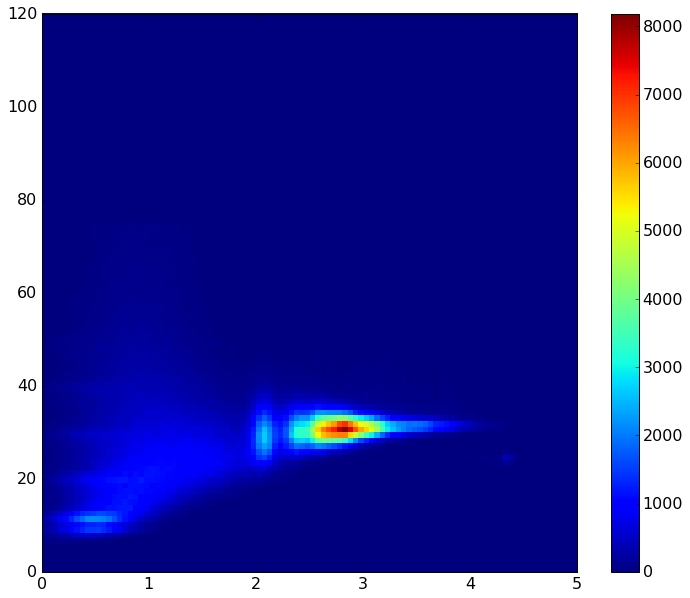

In [157]:
plt.hist2d(np.log10(data['cs1']), #np.log10(data['cs2']), 
           data['s1_range_area_decile_5'],
           #s=2, edgecolors='none', vmin=50, vmax=100
           bins=100, range=((0, 5), (0, 120)),
          )
plt.colorbar()

# Bla

In [19]:
from collections import defaultdict

class NoEventsFound(Exception):
    pass

class DataExtractor(object):
    cache_size = 1000
    extra_branches = tuple()
    
    def __init__(self):
        self.cache = []

    def get_data(self, datasets, **kwargs):
        """Return data extracted from running over datasets"""
        for ds in datasets:
            # Check for cached file
            
            # Create hdf5 file
            self.run(ds, **kwargs)
        
            loop_over_root_events(datasets, self.process_event, 
                                  branch_selection=BASIC_BRANCHES + list(self.extra_branches),
                                  **kwargs)
            self.check_cache()
            if not hasattr(self, 'data'):
                raise NoEventsFound("Not a single event was extracted!")
            else:
                self.data.to_hdf('xe100_120402_1116.hdf5', 'data')
                return self.data
                del self.data
    
    def process_event(self, event):
        event_data = dict(event_number=event.event_number,
                          event_time=event.start_time)
        
        # Detect events without at least one S1 + S2 pair immediatly
        # We cannot even fill the basic variables for these
        if len(event.interactions) != 0:

            # Extract basic data: useful in any analysis
            interaction = event.interactions[0]
            s1 = event.peaks[interaction.s1]
            s2 = event.peaks[interaction.s2]
            event_data.update(dict(s1_corrected_area=s1.area * interaction.s1_area_correction,
                                   s2_corrected_area=s2.area * interaction.s2_area_correction,
                                   x=interaction.x,
                                   y=interaction.y,
                                   z=interaction.z))

            # Add double scatter data:
            # area of the second largest peak of each peak type
            #largest_area_of_type = defaultdict(float)
            #for i, p in enumerate(event.peaks):
            #    if i == interaction.s1 or i == interaction.s2:
            #        continue
            #    largest_area_of_type[p.type] = max(p.area, largest_area_of_type[p.type])
            #event_data.update({'largest_other_%s' % p_type: area
            #                   for p_type, area in largest_area_of_type.items()})

            # Add any extra data
            event_data.update(self.extract_data(event))
        
        # Append this event dictionary to the cache
        # If we would append every dict to the dataframe individually the code runs ~5x slower
        self.cache.append(event_data)
        self.check_cache()

    def check_cache(self):
        if len(self.cache) < 100:
            return
        if not hasattr(self, 'data'):
            # Create the dataframe self.data
            self.data = pandas.DataFrame(self.cache)
        else:
            # Append to the dataframe self.data
            self.data = self.data.append(self.cache)
        self.cache = []
            
    def extract_data(self, event):
        """Override this to extract extra data"""
        return {}

Here's how you might extract data for an S1 Pulse shape analysis:

In [16]:
# Define your data extractor
class S1PulseShapeData(DataExtractor):
    extra_branches = ['peaks.range_area_decile*']
    
    def extract_data(self, event):
        s1 = event.peaks[event.interactions[0].s1]
        return dict(s1_width=s1.range_area_decile[5])
    
# Run it over the AmBe Datasets
ambe_datasets = datasets.query('source == "AmBe" & category == "standard"')['name'].values
extractor = S1PulseShapeData()
for ds in ambe_datasets:
    try:
        data = extractor.run(ds, rootfiles_path='/archive_lngs/common/PaxReprocessed_6')
    except NoEventsFound:
        continue
    break

 24%|██▍       | 41835/172506 [00:05<00:17, 7356.28it/s]

ROOT file /archive_lngs/common/PaxReprocessed_6/xe100_110210_1100.root does not exist!
ROOT file /archive_lngs/common/PaxReprocessed_6/xe100_110210_1106.root does not exist!
ROOT file /archive_lngs/common/PaxReprocessed_6/xe100_110210_1412.root does not exist!
ROOT file /archive_lngs/common/PaxReprocessed_6/xe100_110210_1502.root does not exist!
ROOT file /archive_lngs/common/PaxReprocessed_6/xe100_110210_1709.root does not exist!
ROOT file /archive_lngs/common/PaxReprocessed_6/xe100_110210_1926.root does not exist!
ROOT file /archive_lngs/common/PaxReprocessed_6/xe100_110210_2211.root does not exist!
ROOT file /archive_lngs/common/PaxReprocessed_6/xe100_110210_2341.root does not exist!
ROOT file /archive_lngs/common/PaxReprocessed_6/xe100_110211_0059.root does not exist!
ROOT file /archive_lngs/common/PaxReprocessed_6/xe100_110211_0315.root does not exist!
ROOT file /archive_lngs/common/PaxReprocessed_6/xe100_110211_0532.root does not exist!
ROOT file /archive_lngs/common/PaxReprocess

KeyboardInterrupt: 

In [13]:
data.head(10)

,event_number,event_time,largest_other_coincidence,largest_other_lone_hit,largest_other_s1,largest_other_s2,largest_other_unknown,s1_corrected_area,s1_width,s2_corrected_area,x,y,z
0,0,17209600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,158737408,NaN,2.26527,1443.130371,1346.459351,NaN,0.917025,8.674466,1.881503,-3.163534,-9.366541,27.328867
2,2,267368448,NaN,1.41097,1602.500122,129038.656250,NaN,0.681863,10.723487,1.506214,-8.250000,-3.287594,26.551046
3,3,279134464,NaN,2.10861,3.215195,258.598572,NaN,0.412947,5.841413,0.438215,-9.242481,11.103383,14.631066
4,4,341927424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,367920384,NaN,1.91924,25.988556,129.870728,NaN,1.363324,10.251830,1.405918,-4.031955,13.956767,13.969340
6,6,461978368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,577152512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,579998464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,746592512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [337]:
# Remove double scatters (standard XENON100 double scatter cut, note the 67)
cut_data = data[data['largest_other_s2'] > np.clip(data['s2_corrected_area']/100, 67, float('inf'))]

# Remove VERY rare cases where no position could be found, so corrected area is NaN
cut_data = cut_data[(cut_data['s1_corrected_area'] > 0) & (cut_data['s2_corrected_area'] > 0)]

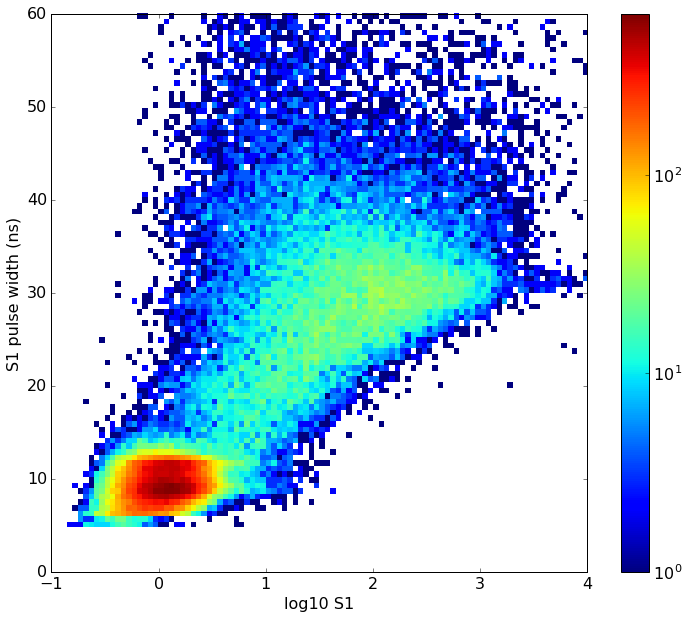

In [347]:
plt.hist2d(np.log10(cut_data['s1_corrected_area']), 
           cut_data['s1_width'],
           #c=np.log10(cut_data['s2_corrected_area']), 
           #s=2, edgecolor='none', alpha=0.5,
           range=((-1, 4), (0, 60)),
           bins=100, norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.xlabel('log10 S1')
plt.ylabel('S1 pulse width (ns)')
plt.show()